## HYPOTHESIS II: infection dynamics

Evaluation moments: 

1.	First of food distribution  (tick = 10080, day = 7)

2.	First food distribution plus incubation time (ticks = 18720, day = 13)

3.	Second food distribution (ticks = 50400, day = 35)

4.	Second food distribution plus incubation time (ticks = 59040, day = 41)




In [ ]:
## dont forget to render it nicely

In [ ]:
##### IMPORTING NECESSARY LIBRARIES
import os
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('white')
from string import digits
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.style.reload_library()
plt.style.use(['science','grid']) ############## THIS ONE TO COOL EVERYTHING
import re
from IPython.display import display

In [ ]:
##### DATA FOR STRUCTURING OF THE WHOLE NOTEBOOK
# scenarios
number_of_scenarios = 5
scenarios = [0,10,20,30]
scenarios_with40 = [0, 10, 20, 30, 40]
scenario_names = ['S0','S1','S2','S3']
scenario_names_with40 = ['S0','S1','S2','S3','S4']
number_of_scenarios_of_interest = 2
scenarios_of_interest = [10, 30]
scenarios_of_interest_number = [1,3]
scenarios_of_interest_names = ['S1', 'S3']
# replications
number_of_replications = 10
replications = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
replications_dictionary = [0,1,2,3,4,5,6,7,8,9]
# moments of evaluation
evaluation_moments_ticks = [10080, 18720, 50400, 59040]
evaluation_moments_day = [7, 13, 35, 41]
# palettes
pal_scenarios = {0: "tab:blue", 1: "tab:orange", 2:"tab:green", 3: "tab:purple", 4:"tab:red"}
pal_scenarios_10 = {0: "tab:blue", 10: "tab:orange", 20:"tab:green", 30: "tab:purple", 40:"tab:red"}
pal_scenarios_interest = {10: "tab:orange", 30: "tab:purple"}
pal_attitudes = {"Cooperative": "tab:gray", "Competitive": "tab:pink", 'New-competitive':"tab:olive"}
pal_locations = {"shelter": "lightcoral", "waterpoint": "goldenrod", 'fooddistro':"tab:brown", 'latrine': "tab:cyan", "hc-fac":"cornflowerblue"}
pal_likelihood_attitudes= {'likelihood-cooperative': "tab:gray", "likelihood-competitive": "tab:pink", "likelihood-newcompetitive": "tab:olive"}


In [ ]:
##### DIRECTORIES
directory_location = '/datasets/experiment0/'
location_figures = 'figures_eva_baseline/'

In [ ]:
##### FUNCTIONS TO BE USED 
### Function to read the text files that NetLogo outputs
def organise_in_dict(string):
    trigger = False 
    open_char = '['
    close_char = ']'
    skipper = False
        
    counter = 0
    d = {}
    tmplist = ''
    for char_index in range(len(string)-1):
        
        char = string[char_index]
        next_char = string[char_index+1]

        if char == open_char and counter!=5 and skipper == False:# skipper==False:
            tmplist=''
            

        if char == open_char and counter == 5 and skipper == False:
            skipper = True
            tmplist=''
            
  
        if char != open_char and char!= close_char:
            tmplist=tmplist+char
            
        if char == close_char and skipper==False:
            d[counter] = tmplist
            counter+=1
            
        if char == close_char and next_char == close_char and skipper==True:
            skipper=False
    return d
######    
    
    
### Function to clean the values of each cell from the dictionary above
def clean(string,dict_key):

    remove_digits = str.maketrans('', '', digits)

    def remove_end_spaces(string):
        return "".join(string.rstrip())

    def Convert(string):
        li = list(string.split(" "))
        return li

    def cleaning_list_locations(cell_from_dataframe,dict_key=dict_key):
        cleaning_cell = cell_from_dataframe.replace("(","").replace(")","").replace('"', "")
        if dict_key!=5:
            cleaning_cell = cleaning_cell.translate(remove_digits)

        cleaning_cell = re.sub("\s\s+", " ", cleaning_cell)
        cleaning_cell = remove_end_spaces(cleaning_cell)
        cleaning_cell = Convert(cleaning_cell)

    
        return cleaning_cell

    def replacing_nonepatch_shelter(almost_finished_list):

        for n, i in enumerate(almost_finished_list):
           if i == "none":
              almost_finished_list[n] = "shelter"
           if i == "patch":
              almost_finished_list[n] = "shelter"
            
        return almost_finished_list
    
    filtered_string = cleaning_list_locations(string)
    filtered_string = replacing_nonepatch_shelter(filtered_string)
    
    return filtered_string
######

###
def func(filename,directory_location):
    
    file_as_string = open(directory_location+filename).read()
    
    file_as_dict = organise_in_dict(file_as_string)
    
    final_dict = {}
    
    for key in file_as_dict:
        if key > 5 or key == 0:
            final_dict[key] = file_as_dict[key].split()
            pass
        else:
            final_dict[key] = clean(file_as_dict[key],dict_key=key)
        
    return final_dict
######


In [ ]:
##### PREPARING DATA 
### TEXT-FILES: Putting all the info in the textfiles in a dictionary with levels: scenario, replication
filenames = list()
total_dict = {}

for scenario in range(number_of_scenarios):
    total_dict[scenario] = {}
    
    for replication in range(number_of_replications):
        filename = 'Ex0_Second_Policy_policy 0 (baseline)_scenario_%s_run_%s'%(scenario*10,scenario*10+1+replication)
        
        total_dict[scenario][replication] = func(filename=filename,directory_location=directory_location)
#####
      

### Creating a new column in each replication level with the number of times ....      
for scenario in total_dict:
    
    for replication in total_dict[scenario]:
        total_dict[scenario][replication][9] = {'cooperative':0,'competitive':0, 'new-competitive':0}
        counters = {'cooperative':0,'competitive':0, 'new-competitive':0}
        somearray = total_dict[scenario][replication][5]
        
        for index in range(int(len(somearray)/2)):
            total_dict[scenario][replication][9][somearray[index*2]] += float(somearray[index*2+1])
            counters[somearray[index*2]] += 1
            
        
    
        for key in total_dict[scenario][replication][9]:
            
            if counters[key] != 0:
                total_dict[scenario][replication][9][key]=total_dict[scenario][replication][9][key]/counters[key]
                
print("I have prepared the info from the text files!")
################################            

### .CSV FILE: with info per tick
exp0df = pd.read_csv(directory_location + "CoupledModel_afterGL_255 Ex0_BaselineAllScenarios_secondtry-table.csv", skiprows=6)
print("I have finished reading the .csv file!")
###############

## renaming columns 

exp0df.columns = ['run',
                  'initial-corona-number',
                  'policy-implemented',
                  'policy4?',
                  'scenario:percentage-competitive',
                  'step',
                  'ticks',
                  'day',
                  'hour',
                  'minute',
                  'count-tents',
                  'infected-elderly', #count tents with [(my-age = "elderly") and (infected? = true)]',
                  'infected-children', #count tents with [(my-age = "child") and (infected? = true)]',
                  'infected-adults', #count tents with [(my-age = "adult") and (infected? = true)]',
                  'cum-dead',
                  'cum-recovered',
                  'time-in-queue-average',
                  'time-in-queue-cooperative',
                  'time-in-queue-competitive',
                  'time-in-queue-newcompetitive',
                  'total-served',
                  'number-competitive-joining',
                  'number-new-competitive',
                  'nbr-infectious',
                  'nbr-infectious-competitive',
                  'nbr-infectious-cooperative',
                  'infections-provoked-cooperative-average',
                  'infections-provoked-cooperative-total',
                  'infections-provoked-competitive-average',
                  'infections-provoked-competitive-total',
                  'number-acting-competitive',
                  'attitude-and-infections',
                  'number_dailyinfections_perlocation'] 

                  

# creating a column with the cumulative cases 
exp0df['cum_infected'] = exp0df['infected-elderly'] + exp0df['infected-children'] + exp0df['infected-adults']



#Find the maxmimum values for every day (end of the day value; assumption):
exp0df = exp0df.pivot_table(values = ['nbr-infectious','cum_infected', "nbr-infectious-competitive", "nbr-infectious-cooperative", 'infections-provoked-cooperative-total', 'infections-provoked-competitive-total', 'number-new-competitive', 'number-competitive-joining', 'total-served', 'time-in-queue-average'], index = ['scenario:percentage-competitive', 'policy-implemented', 'policy4?','run','day'], aggfunc = np.max)

#Calculate the differences between these values to obtain daily infections:
exp0df['daily-infections'] = exp0df['cum_infected'].diff()
exp0df['daily-provoked-cooperative'] = exp0df['infections-provoked-cooperative-total'].diff()
exp0df['daily-provoked-competitive'] = exp0df['infections-provoked-competitive-total'].diff()


#Reset index to obtaine a normal df format again, without multi index:
exp0df.reset_index(inplace = True)

# At Day 0 of each run, the daily infections should equal 0, 
#instead of a negative value that occurs when calcuating the 
#difference with the last day of the previous run:
exp0df['daily-infections'] = np.where(exp0df['day'] == 0, 0, exp0df['daily-infections'])
exp0df['daily-provoked-cooperative'] = np.where(exp0df['day'] == 0, 0, exp0df['daily-provoked-cooperative'])
exp0df['daily-provoked-competitive'] = np.where(exp0df['day'] == 0, 0, exp0df['daily-provoked-competitive'])



# Defining R0 per attitude
exp0df['R0'] = exp0df['daily-infections']/exp0df['nbr-infectious']
## not sure if i can call these R0, look it up 
exp0df['r0-cooperative'] = exp0df['daily-provoked-cooperative']/exp0df['nbr-infectious-cooperative']  
exp0df['r0-competitive'] = exp0df['daily-provoked-competitive']/exp0df['nbr-infectious-competitive']


exp0df = exp0df.reset_index()


print("I have prepared the info from the .csv file!")

#####################################



I have prepared the info from the text files!
I have finished reading the .csv file!
I have prepared the info from the .csv file!


In [ ]:
# evaluating the dataframe for the .csv file 
exp0df.head()

,index,scenario:percentage-competitive,policy-implemented,policy4?,run,day,cum_infected,infections-provoked-competitive-total,infections-provoked-cooperative-total,nbr-infectious,...,number-competitive-joining,number-new-competitive,time-in-queue-average,total-served,daily-infections,daily-provoked-cooperative,daily-provoked-competitive,R0,r0-cooperative,r0-competitive
0,0,0,policy 0 (baseline),False,1,0,1,0,0,0,...,0,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN
1,1,0,policy 0 (baseline),False,1,1,1,0,0,0,...,0,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN
2,2,0,policy 0 (baseline),False,1,2,1,0,0,0,...,0,0,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN
3,3,0,policy 0 (baseline),False,1,3,3,0,2,1,...,0,0,0.0,0,2.0,2.0,0.0,2.0,2.0,NaN
4,4,0,policy 0 (baseline),False,1,4,3,0,2,1,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN


### 3. 1 The competitiveness of a population has an effect on the total number of infections (over time?)


The graph of the cumulative number of infections over time


	Show for the four different evaluation moments -- with Boxplots
    
The four evaluation moments are only of interest when evaluating the infection dynamics. (coincides with the limited sensitivity of the output (at end of runtime) to varying the competitiveness of the population). 

- the normal graph (timeseries) + the introduction of vertical lines (thick red ones) at the evaluation moments xavline 

- make scneario selection if you want (scenario 10% and 30%)

- fill a matrix with all the data

- make 8 boxplots (2 scenarios and four time moments) -- divide into different subplots because of the axis


#### 3.1.1 Cumulative plot with a mark highlighting the four important places


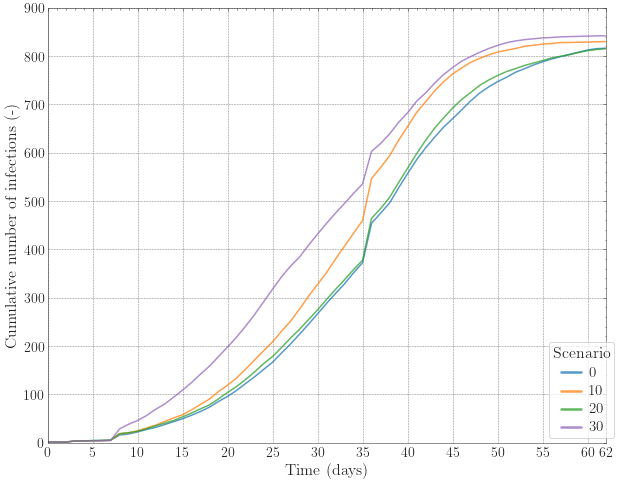

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

for j in scenarios:
    df = exp0df
    df = df[df['scenario:percentage-competitive'] == j]
    df.groupby('day').mean()['cum_infected'].plot(ax=ax, label=j, color = pal_scenarios_10[j], linewidth = 1.5,alpha=0.75) # Always add 'alpha' to make slightly transparent to avoid pixely lines hashtag life hack

#for moments in evaluation_moments_day:
#    ax.axvline(x=moments, color = "black", linestyle = "--")
    
   

leg = plt.legend(loc='lower right', bbox_to_anchor=(1.025, 0),framealpha=0.75,title='Scenario',title_fontsize=16)
# get the individual lines inside legend and set line width

# Adjust the linewidth of the legend
for line in leg.get_lines():
    line.set_linewidth(2.5)
for text in leg.get_texts():
    text.set_fontsize(15)
    
    

# Correct xticks, make it 'convenient' to read what you need to read (i guess interval of 5 days )
ax.set_xlim([0,df['day'].max()])

xticks = np.linspace(0,60,13)
xticks = np.append(xticks,62)

xticklabels = list() # 
for xt in range(len(xticks)):
    xticklabels.append( str(int(xticks[xt])))
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=14)


# Correct yticks, again, make them convenient. the default 100 is a good step here i guess 
# Correct y-lim
ax.set_ylim([0,900])

ax.set_ylabel('Cumulative number of infections (-)', fontsize = 16)

yticks = np.linspace(0,900,10)

yticklabels = list() # 
for yt in range(len(yticks)):
    yticklabels.append( str(int(yticks[yt])))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=14)




ax.set_xlabel('Time (days)', fontsize = 16)
#fig.suptitle('Cumulative infections: Baseline in each scenario', fontsize=20)
plt.savefig(location_figures + "Hypothesis2.1.1CumulativeInfections.svg")

#### Instead of this image, show a spaggheti plot to show behaviour (all converge to a similar value) + boxplot (to show differences between them)

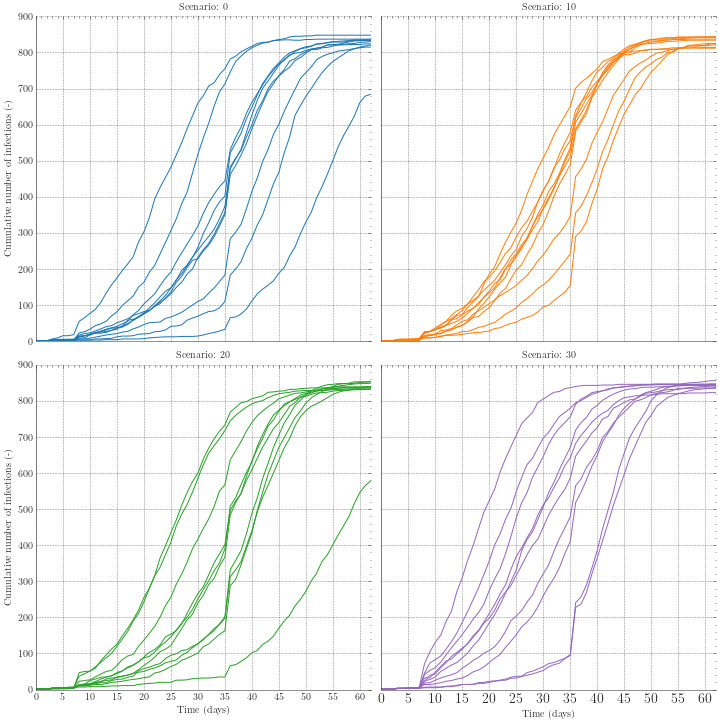

In [ ]:
exp0df_without40 = exp0df[exp0df['scenario:percentage-competitive'] != 40]
g = sns.relplot(x = 'day', y = 'cum_infected',col = 'scenario:percentage-competitive', style = 'run', legend = False, col_wrap=2, palette = pal_scenarios_10, hue = 'scenario:percentage-competitive', kind = 'line', data = exp0df_without40, dashes= False).set_axis_labels("Time (days)", "Cumulative number of infections (-)").set_titles("Scenario: {col_name} % competitive")

ax = plt.gca()
# Correct xticks, make it 'convenient' to read what you need to read (i guess interval of 5 days )
ax.set_xlim([0,df['day'].max()])

xticks = np.linspace(0,60,13)

xticklabels = list() # 
for xt in range(len(xticks)):
    xticklabels.append( str(int(xticks[xt])))
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=14)

# Correct yticks, again, make them convenient. the default 100 is a good step here i guess 
# Correct y-lim
ax.set_ylim([0,900])

ax.set_ylabel('Cumulative number of infections (-)', fontsize = 16)

yticks = np.linspace(0,900,10)

yticklabels = list() # 
for yt in range(len(yticks)):
    yticklabels.append( str(int(yticks[yt])))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=14)

g.savefig(location_figures + "Hypothesis2.1.1Baseline_CumulativeInfections_Spaghetti.svg")

# From this image, it is possible to observe a similar behavior across all scenarios with all the runs (exceot for two)
# converging to a total infection 


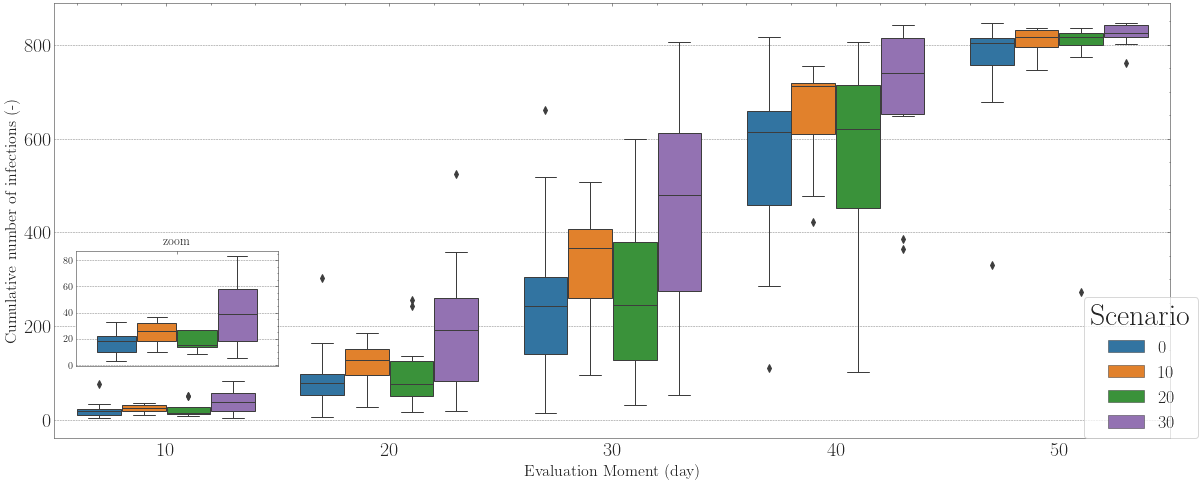

In [ ]:
# However, the graph above doesnt show how these scenarios differ from each other 
exp0df_without40 = exp0df[exp0df['scenario:percentage-competitive'] != 40]

several_moments = [10,20,30,40,50]

df_allscenarios_evaluationmoment = exp0df_without40[ exp0df_without40["day"].isin(several_moments)]

fig, ax = plt.subplots(figsize = (20, 8))

fig = sns.boxplot(x="day", y="cum_infected",
            hue="scenario:percentage-competitive",
            data=df_allscenarios_evaluationmoment, palette=pal_scenarios_10)


leg = plt.legend(loc='lower right', bbox_to_anchor=(1.025, 0),framealpha=0.75,title='Scenario',title_fontsize=30, borderaxespad=0, fontsize='x-large', prop={'size':18})


ax.set_xlabel("Evaluation Moment (day)", size = 16)
ax.set_ylabel("Cumulative number of infections (-)", size = 16)

# ax.tick_params(axis='y', labelsize=20)
# ax.tick_params(axis='x', labelsize=20)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

listOf_Yticks = np.arange(0, 800, 200)

ax2 = plt.axes([0.14, 0.25, .14, .2])
sns.boxplot(x="day", y="cum_infected",
            hue="scenario:percentage-competitive",
            data=df_allscenarios_evaluationmoment[df_allscenarios_evaluationmoment["day"] == 10], palette=pal_scenarios_10, linewidth=1, ax=ax2, showfliers=False)

ax2.get_legend().remove()
ax2.set_xlabel(None)
ax2.set_xticklabels([None])
ax2.set_ylabel(None)
ax2.set_title('zoom')
# ax2.set_xlim([])


#ax.set_title("Cumulative infections over time",fontsize=20)
plt.savefig(location_figures + "Hypothesis2.1.2CumulativeInfectionsDifferentDays.svg")

In [ ]:
dd

,index,scenario:percentage-competitive,policy-implemented,policy4?,run,day,cum_infected,infections-provoked-competitive-total,infections-provoked-cooperative-total,nbr-infectious,...,number-competitive-joining,number-new-competitive,time-in-queue-average,total-served,daily-infections,daily-provoked-cooperative,daily-provoked-competitive,R0,r0-cooperative,r0-competitive
630,630,10,policy 0 (baseline),False,11,0,1,0,0,0,...,0,0,0.000000,0,0.0,0.0,0.0,NaN,NaN,NaN
631,631,10,policy 0 (baseline),False,11,1,1,0,0,0,...,0,0,0.000000,0,0.0,0.0,0.0,NaN,NaN,NaN
632,632,10,policy 0 (baseline),False,11,2,1,0,0,0,...,0,0,0.000000,0,0.0,0.0,0.0,NaN,NaN,NaN
633,633,10,policy 0 (baseline),False,11,3,5,0,4,1,...,0,0,0.000000,0,4.0,4.0,0.0,4.000000,4.000000,NaN
634,634,10,policy 0 (baseline),False,11,4,6,0,5,1,...,0,0,0.000000,0,1.0,1.0,0.0,1.000000,1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2515,30,policy 0 (baseline),False,40,58,844,297,548,73,...,106,147,651.872159,352,0.0,0.0,0.0,0.000000,0.000000,0.0
2516,2516,30,policy 0 (baseline),False,40,59,846,297,550,73,...,106,147,651.872159,352,2.0,2.0,0.0,0.027397,0.037037,0.0
2517,2517,30,policy 0 (baseline),False,40,60,846,297,550,52,...,106,147,651.872159,352,0.0,0.0,0.0,0.000000,0.000000,0.0
2518,2518,30,policy 0 (baseline),False,40,61,847,297,551,52,...,106,147,651.872159,352,1.0,1.0,0.0,0.019231,0.023810,0.0


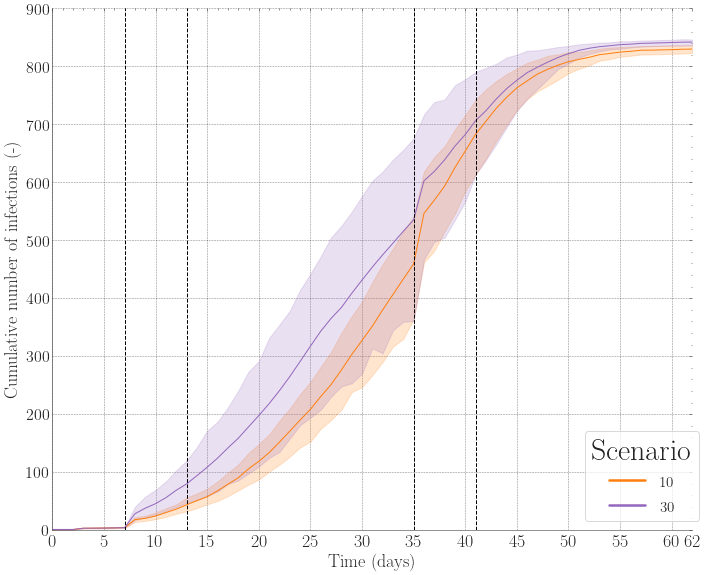

In [ ]:
# g = plt.figsize((10, 8))

dd = exp0df[(exp0df['scenario:percentage-competitive'] == 10) | (exp0df['scenario:percentage-competitive'] == 30)]

g = sns.relplot(data= dd, x="day", y="cum_infected", kind = 'line', hue="scenario:percentage-competitive", legend=False, palette = pal_scenarios_interest)
# g.set(xlabel='Time (days)', ylabel='Cumulative number of infections (-)')
g.fig.set_size_inches(10,8)

leg = plt.legend(labels = [10, 30], loc='lower right', bbox_to_anchor=(1.025, 0),framealpha=0.75,title='Scenario',title_fontsize=30, prop={'size':18})

ax = plt.gca()

#for moments in evaluation_moments_day:
#    ax.axvline(x=moments, color = "black", linestyle = "--")
ax.axvline(x=7, color='black', linestyle='--')
ax.axvline(x=13, color='black', linestyle='--')
ax.axvline(x=35, color='black', linestyle='--')
ax.axvline(x=41, color='black', linestyle='--')

# Adjust the linewidth of the legend
for line in leg.get_lines():
    line.set_linewidth(2.5)
for text in leg.get_texts():
    text.set_fontsize(15)
    
    

# Correct xticks, make it 'convenient' to read what you need to read (i guess interval of 5 days )
ax.set_xlim([0,dd['day'].max()])

xticks = np.linspace(0,60,13)
xticks = np.append(xticks,62)

xticklabels = list() # 
for xt in range(len(xticks)):
    xticklabels.append( str(int(xticks[xt])))
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=18)

# Correct yticks, again, make them convenient. the default 100 is a good step here i guess 
# Correct y-lim
ax.set_ylim([0,900])

ax.set_ylabel('Cumulative number of infections (-)', fontsize = 18)
ax.set_xlabel('Time (days)', fontsize = 18)

yticks = np.linspace(0,900,10)

yticklabels = list() # 
for yt in range(len(yticks)):
    yticklabels.append( str(int(yticks[yt])))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=16)

g.savefig(location_figures + "Hypothesis2.1.1CumulativeInfectionsWITHBANDSANDLINES.svg")


#### 3.1.2. 8 Boxplots with the number of cumulative cases at the four points of interest in s1 and s3

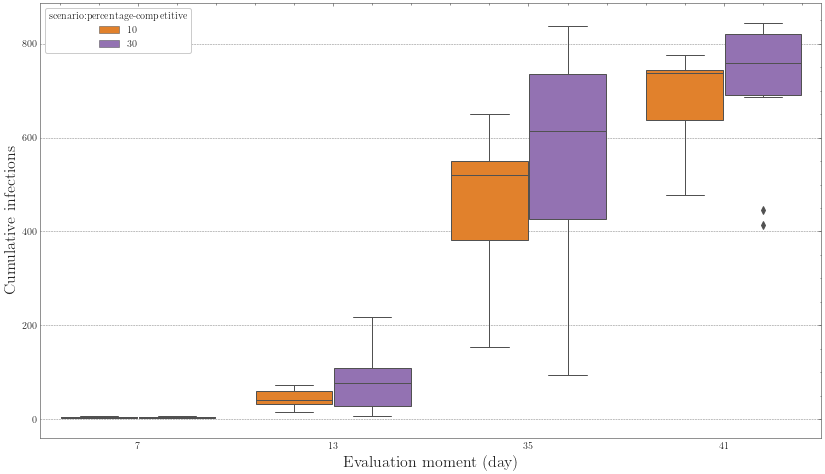

In [ ]:
df_s1s3_evaluationmoments = exp0df[(exp0df["scenario:percentage-competitive"].isin(scenarios_of_interest)) 
                                                   & (exp0df["day"].isin(evaluation_moments_day))]
fig, ax = plt.subplots(figsize = (14, 8))

fig = sns.boxplot(x="day", y="cum_infected",
            hue="scenario:percentage-competitive",
            data=df_s1s3_evaluationmoments, palette=pal_scenarios_10)


ax.set_xlabel("Evaluation moment (day)", size = 16)
ax.set_ylabel("Cumulative infections", size = 16)
#ax.set_title("Cumulative infections over time",fontsize=20)
plt.savefig(location_figures + "Hypothesis2.1.2CumulativeInfectionsS1S3EvaluationMoments.svg")

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


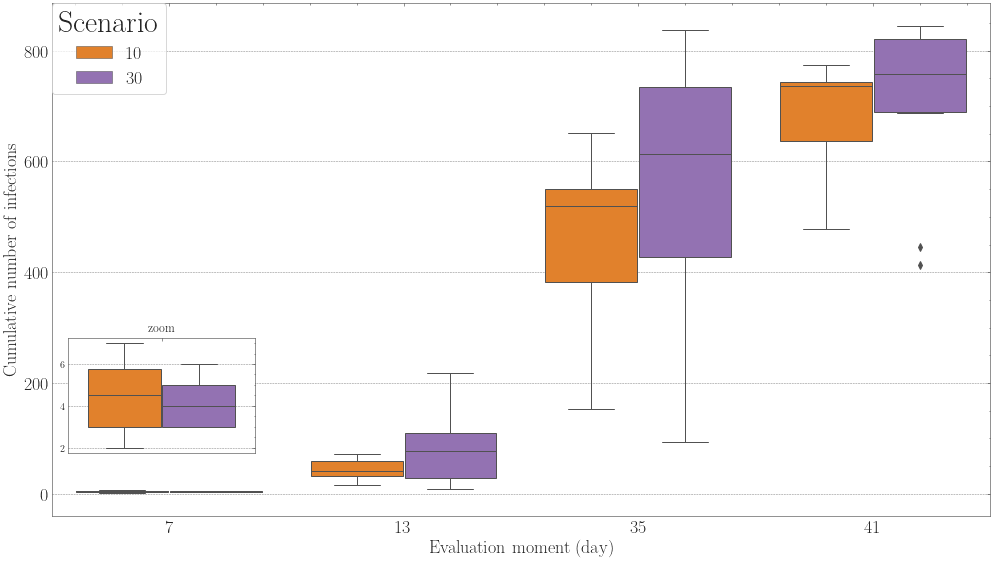

In [ ]:
## slightly improving this by including a zoom for day 7


fig, ax = plt.subplots(figsize = (14, 8))

fig = sns.boxplot(x="day", y="cum_infected",
            hue="scenario:percentage-competitive",
            data=df_s1s3_evaluationmoments, palette=pal_scenarios_10, linewidth=1)

plt.legend(framealpha=0.75,title='Scenario',title_fontsize=30, borderaxespad=0, fontsize='x-large', prop={'size':18})


listOf_Yticks = np.arange(0, 800, 200)
# ax.set_yticks(listOf_Yticks)
ax.set_xlabel("Evaluation moment (day)", size = 18)
ax.set_ylabel("Cumulative number of infections", size = 18)
#ax.set_title("Cumulative infections over time",fontsize=20)
# ax.set_yticks([5])

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

ax2 = plt.axes([0.075, 0.2, .185, .2])
sns.boxplot(x="day", y="cum_infected",
            hue="scenario:percentage-competitive",
            data=df_s1s3_evaluationmoments[df_s1s3_evaluationmoments["day"] == 7], palette=pal_scenarios_10, linewidth=1, ax=ax2, showfliers=False)

ax2.get_legend().remove()
ax2.set_xlabel(None)
ax2.set_xticklabels([None])
ax2.set_ylabel(None)
ax2.set_title('zoom')
# ax2.set_xlim([])

plt.tight_layout()
plt.savefig(location_figures + "Hypothesis2.1.2CumulativeInfectionsS1S3EvaluationMoments.svg")

<span style='color:green'> What kind of comments can I take from this? </span>
*



### 3.2 The competitiveness of a population has an effect on the number of infections per specified location at four moments in s01 s03

In [ ]:
for scenario in total_dict:

    for replication in total_dict[scenario]: 
    
        run_number = scenario*number_of_replications + 1 + replication 
        
        selected_df = exp0df[exp0df['run'] == run_number ] 
        
        tempdict = {}
        
        for day in evaluation_moments_day:
            
            number_of_infections = selected_df.loc[selected_df['day'] == day,'cum_infected'].iloc[0]
            tempdict[day] = total_dict[scenario][replication][1][0:number_of_infections - 1]
            
        total_dict[scenario][replication][10] = tempdict
        
matrix= np.zeros([number_of_replications*number_of_scenarios, 6])

locations = ['shelter','waterpoint', 'latrine', 'hc-fac', 'fooddistro']
    
for scenario in total_dict:
    for replication in total_dict[scenario]:  
        total_dict[scenario][replication][11] = {7: 0, 13: 0, 35: 0, 41: 0}
        
        for evaluation_day in total_dict[scenario][replication][10]:
            count_shelter = 0
            count_waterpoint = 0
            count_latrine = 0
            count_hcfac = 0
            count_fooddistro = 0
            
            temp_loc_dict = {}
            
            for entry in total_dict[scenario][replication][10][evaluation_day]:
      
                if entry == 'shelter':
                    count_shelter = count_shelter + 1
                if entry == 'waterpoint':
                    count_waterpoint = count_waterpoint + 1
                if entry == 'latrine':
                    count_latrine = count_latrine + 1
                if entry == 'hcfac':
                    count_hcfac = count_hcfac + 1
                if entry == 'fooddistro':
                    count_fooddistro = count_fooddistro + 1
            
            
            temp_loc_dict[evaluation_day] = {'shelter': count_shelter, 'waterpoint': count_waterpoint,
                                               'latrine': count_latrine, 'hcfac': count_hcfac,
                                               'fooddistro': count_fooddistro}
            
            total_dict[scenario][replication][11][evaluation_day] = temp_loc_dict[evaluation_day]



In [ ]:
# now I have a 11th column with the counter of infections per moment of evaluation

total_dict[3][1][11]

{7: {'shelter': 2, 'waterpoint': 0, 'latrine': 0, 'hcfac': 0, 'fooddistro': 0},
 13: {'shelter': 47,
  'waterpoint': 5,
  'latrine': 3,
  'hcfac': 0,
  'fooddistro': 36},
 35: {'shelter': 245,
  'waterpoint': 168,
  'latrine': 133,
  'hcfac': 0,
  'fooddistro': 36},
 41: {'shelter': 281,
  'waterpoint': 206,
  'latrine': 201,
  'hcfac': 0,
  'fooddistro': 55}}

In [ ]:
## CREATING 4 MATRIX TO STORE THE DATA FOR THE INFECTION PER LOCATION




# For the first moment of evaluation

matrix_firstmoment = np.zeros([number_of_replications*number_of_scenarios,7])
for scenario in total_dict:
    for replication in total_dict[scenario]:
        matrix_firstmoment[number_of_replications*scenario+replication,0] = scenario
        matrix_firstmoment[number_of_replications*scenario+replication,1] = replication
        matrix_firstmoment[number_of_replications*scenario+replication,2] = total_dict[scenario][replication][11][7]['shelter']
        matrix_firstmoment[number_of_replications*scenario+replication,3] = total_dict[scenario][replication][11][7]['waterpoint']
        matrix_firstmoment[number_of_replications*scenario+replication,4] = total_dict[scenario][replication][11][7]['latrine']
        matrix_firstmoment[number_of_replications*scenario+replication,5] = total_dict[scenario][replication][11][7]['hcfac']
        matrix_firstmoment[number_of_replications*scenario+replication,6] = total_dict[scenario][replication][11][7]['fooddistro']

matrix_firstmoment = pd.DataFrame(matrix_firstmoment, columns = ["scenario", "replication", "shelter", "waterpoint", "latrine", "hc-fac", "fooddistro" ])
# only selecting scenario 1 and scenario 3
matrix_firstmoment = matrix_firstmoment[(matrix_firstmoment['scenario'] == 1.0) | (matrix_firstmoment['scenario'] == 3.0)]
matrix_firstmoment = matrix_firstmoment.melt(id_vars=['scenario', 'replication'], 
              value_vars=[ "shelter", "waterpoint", "latrine", "fooddistro"],
              var_name='Location', value_name='Infections')

# For the second moment of evaluation

matrix_secondmoment = np.zeros([number_of_replications*number_of_scenarios,7])
for scenario in total_dict:
    for replication in total_dict[scenario]:
        matrix_secondmoment[number_of_replications*scenario+replication,0] = scenario
        matrix_secondmoment[number_of_replications*scenario+replication,1] = replication
        matrix_secondmoment[number_of_replications*scenario+replication,2] = total_dict[scenario][replication][11][13]['shelter']
        matrix_secondmoment[number_of_replications*scenario+replication,3] = total_dict[scenario][replication][11][13]['waterpoint']
        matrix_secondmoment[number_of_replications*scenario+replication,4] = total_dict[scenario][replication][11][13]['latrine']
        matrix_secondmoment[number_of_replications*scenario+replication,5] = total_dict[scenario][replication][11][13]['hcfac']
        matrix_secondmoment[number_of_replications*scenario+replication,6] = total_dict[scenario][replication][11][13]['fooddistro']

matrix_secondmoment = pd.DataFrame(matrix_secondmoment, columns = ["scenario", "replication", "shelter", "waterpoint", "latrine", "hc-fac", "fooddistro" ])
# only selecting scenario 1 and scenario 3
matrix_secondmoment = matrix_secondmoment[(matrix_secondmoment['scenario'] == 1.0) | (matrix_secondmoment['scenario'] == 3.0)]
matrix_secondmoment = matrix_secondmoment.melt(id_vars=['scenario', 'replication'], 
              value_vars=[ "shelter", "waterpoint", "latrine", "fooddistro"],
              var_name='Location', value_name='Infections')

# For the third moment of evaluation

matrix_thirdmoment = np.zeros([number_of_replications*number_of_scenarios,7])
for scenario in total_dict:
    for replication in total_dict[scenario]:
        matrix_thirdmoment[number_of_replications*scenario+replication,0] = scenario
        matrix_thirdmoment[number_of_replications*scenario+replication,1] = replication
        matrix_thirdmoment[number_of_replications*scenario+replication,2] = total_dict[scenario][replication][11][35]['shelter']
        matrix_thirdmoment[number_of_replications*scenario+replication,3] = total_dict[scenario][replication][11][35]['waterpoint']
        matrix_thirdmoment[number_of_replications*scenario+replication,4] = total_dict[scenario][replication][11][35]['latrine']
        matrix_thirdmoment[number_of_replications*scenario+replication,5] = total_dict[scenario][replication][11][35]['hcfac']
        matrix_thirdmoment[number_of_replications*scenario+replication,6] = total_dict[scenario][replication][11][35]['fooddistro']

matrix_thirdmoment = pd.DataFrame(matrix_thirdmoment, columns = ["scenario", "replication", "shelter", "waterpoint", "latrine", "hc-fac", "fooddistro" ])
# only selecting scenario 1 and scenario 3
matrix_thirdmoment = matrix_thirdmoment[(matrix_thirdmoment['scenario'] == 1.0) | (matrix_thirdmoment['scenario'] == 3.0)]
matrix_thirdmoment = matrix_thirdmoment.melt(id_vars=['scenario', 'replication'], 
              value_vars=[ "shelter", "waterpoint", "latrine", "fooddistro"],
              var_name='Location', value_name='Infections')

# For the forth and final moment of evaluation

matrix_fourthmoment = np.zeros([number_of_replications*number_of_scenarios,7])
for scenario in total_dict:
    for replication in total_dict[scenario]:
        matrix_fourthmoment[number_of_replications*scenario+replication,0] = scenario
        matrix_fourthmoment[number_of_replications*scenario+replication,1] = replication
        matrix_fourthmoment[number_of_replications*scenario+replication,2] = total_dict[scenario][replication][11][41]['shelter']
        matrix_fourthmoment[number_of_replications*scenario+replication,3] = total_dict[scenario][replication][11][41]['waterpoint']
        matrix_fourthmoment[number_of_replications*scenario+replication,4] = total_dict[scenario][replication][11][41]['latrine']
        matrix_fourthmoment[number_of_replications*scenario+replication,5] = total_dict[scenario][replication][11][41]['hcfac']
        matrix_fourthmoment[number_of_replications*scenario+replication,6] = total_dict[scenario][replication][11][41]['fooddistro']

matrix_fourthmoment = pd.DataFrame(matrix_fourthmoment, columns = ["scenario", "replication", "shelter", "waterpoint", "latrine", "hc-fac", "fooddistro" ])
# only selecting scenario 1 and scenario 3
matrix_fourthmoment = matrix_fourthmoment[(matrix_fourthmoment['scenario'] == 1.0) | (matrix_fourthmoment['scenario'] == 3.0)]
matrix_fourthmoment = matrix_fourthmoment.melt(id_vars=['scenario', 'replication'], 
              value_vars=[ "shelter", "waterpoint", "latrine", "fooddistro"],
              var_name='Location', value_name='Infections')


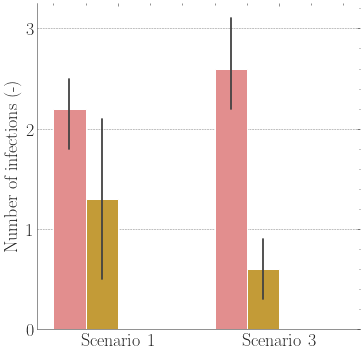

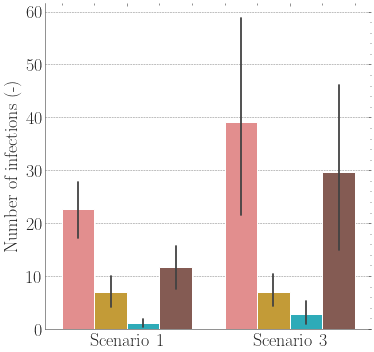

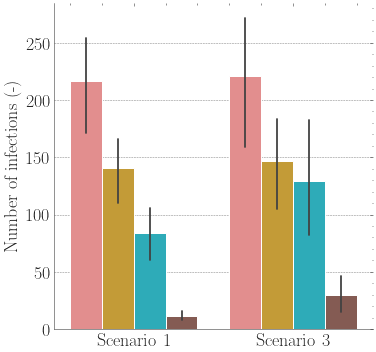

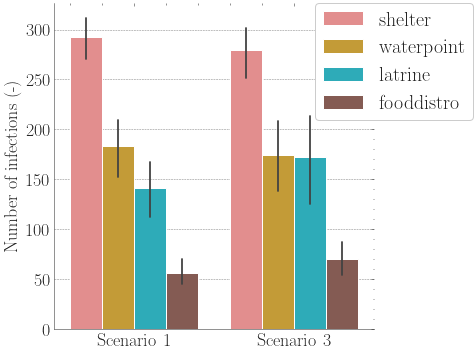

In [ ]:
#### Visualizing the importance of each location at different times of evaluation 


first = sns.catplot(x='scenario', y='Infections', hue='Location', data=matrix_firstmoment, kind='bar', palette=pal_locations)
first._legend.remove()
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.gca().set_xticklabels(["Scenario 1", "Scenario 3"], size = 18)
plt.xlabel(None)
plt.ylabel("Number of infections (-)", size = 18)
plt.yticks(fontsize=18)
#plt.title("Distribution of infections per location: day 7",fontsize=20)
plt.savefig(location_figures + "Hypothesis2.2DistributionInfectionsDay7.svg")

second = sns.catplot(x='scenario', y='Infections', hue='Location', data=matrix_secondmoment, kind='bar', palette=pal_locations)
second._legend.remove()
plt.gca().set_xticklabels(["Scenario 1", "Scenario 3"], size = 18)
plt.xlabel(None)
plt.ylabel("Number of infections (-)", size = 18)
plt.yticks(fontsize=18)
#plt.title("Distribution of infections per location: day 13",fontsize=20)
plt.savefig(location_figures + "Hypothesis2.2DistributionInfectionsDay13.svg")


third = sns.catplot(x='scenario', y='Infections', hue='Location', data=matrix_thirdmoment, kind='bar', palette=pal_locations)
third._legend.remove()
plt.gca().set_xticklabels(["Scenario 1", "Scenario 3"], size = 18)
plt.xlabel(None)
plt.ylabel("Number of infections (-)", size = 18)
plt.yticks(fontsize=18)
#plt.title("Distribution of infections per location: day 35",fontsize=20)
plt.savefig(location_figures + "Hypothesis2.2DistributionInfectionsDay35.svg")

fourth = sns.catplot(x='scenario', y='Infections', hue='Location', data=matrix_fourthmoment, kind='bar', palette=pal_locations, legend= None)
plt.legend(bbox_to_anchor=(1.31, 1), loc=1, borderaxespad=0, fontsize='x-large', title_fontsize='40', prop={'size':20})
#plt.legend(fontsize='x-large', title_fontsize='40')
plt.gca().set_xticklabels(["Scenario 1", "Scenario 3"], size = 18)
plt.xlabel(None)
plt.ylabel("Number of infections (-)", size = 18)
plt.yticks(fontsize=18)
#plt.title("Distribution of infections per location: day 41",fontsize=20)
plt.savefig(location_figures + "Hypothesis2.2DistributionInfectionsDay41.svg")

<span style='color:green'> What kind of comments can I take from this? </span>


* In the second moment of evaluation: Graph 2 the impact of the competitiveness of the population is very clear

* This impact fades out a bit along the run. This can be justified by the immense increase of the infections in the other locations 

* hc fac not included in the graph because there are no infections there at any of these points



### 3.3 The competitiveness of a population has an effect on the location-based infection chain (the contribution of one location to the number of infections at another location)


8 Network graphs (2 scen. 4 ev. Moments); only funnywunny to show if theres actually a difference between them. 


In [ ]:
import networkx as nx

In [ ]:
from sklearn import preprocessing

# Preparing the data for the netowrk graph
locations = ['shelter', 'waterpoint', 'latrine', 'fooddistro', 'hc-fac','patient-zero']
locations_dict = {}
for i in range(len(locations)):
    locations_dict[locations[i]] = i


dict_with_networks = {}
dict_with_graphs = {}

for scenario in total_dict:    
    dict_with_networks[scenario] = {}
    dict_with_graphs[scenario] ={} 
    
    for replication in total_dict[scenario]:
        dict_with_networks[scenario][replication] = {}
        dict_with_graphs[scenario][replication] ={} 
        
        run_number = scenario * number_of_replications + 1 + replication
        selected_df = exp0df[exp0df['run'] == run_number]
        
        tempdict = {}
        
        for day in evaluation_moments_day:
            
            number_of_infections = selected_df.loc[selected_df['day'] == day, 'cum_infected'].iloc[0]
            tempdict[day] = {'infection-location': total_dict[scenario][replication][1][0:number_of_infections - 1], 'previous-infection': total_dict[scenario][replication][3][0:number_of_infections - 1] }
            
            network_matrix = np.zeros([5,6])
            for index in range(len( tempdict[day]['infection-location'])):
                location_infectee =  tempdict[day]['infection-location'][index]
                location_infector =  tempdict[day]['previous-infection'][index]

                row_number = locations_dict[location_infectee]
                column_number = locations_dict[location_infector]

                network_matrix[row_number,column_number] += 1
                

            G = nx.DiGraph()
            
            for loc in locations:
                G.add_node(loc)

            for i in range(5):
                for j in range(6):
                    if network_matrix[i,j]!= 0:
                        G.add_edge(locations[j],locations[i],weight=(network_matrix[i,j])/len(total_dict[scenario][replication][1][0:number_of_infections - 1]))

            dict_with_networks[scenario][replication][day] =  preprocessing.normalize(network_matrix)  ### how do I add the day level here.. nothing is working.. 

            weights = [G[u][v]['weight'] for u,v in G.edges()]
            weights = weights*np.ones(len(weights))*5+np.ones(len(weights))/4



            dict_with_graphs[scenario][replication][day] = [G, weights]

In [ ]:
dict_with_networks[scenario][replication][day]
preprocessing.normalize(dict_with_networks[0][0][13])

array([[0.25819889, 0.51639778, 0.        , 0.77459667, 0.        ,
        0.25819889],
       [0.26726124, 0.        , 0.        , 0.80178373, 0.        ,
        0.53452248],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.86824314, 0.        , 0.        , 0.        , 0.        ,
        0.49613894],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [ ]:
def plot_network_graph(scenario,replication, moment_of_evaluation, dict_with_graphs=dict_with_graphs):
    
    pos = nx.shell_layout(dict_with_graphs[scenario][replication][moment_of_evaluation][0], scale=5)  # positions for all nodes

    def nudge(pos, x_shift, y_shift):
        return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

    pos_nodes = nudge(pos, 0.45, -0.7)


    # nodes
    nx.draw_networkx_nodes(dict_with_graphs[scenario][replication][moment_of_evaluation][0], pos, node_size=400, node_color=pal_scenarios[scenario], alpha=0.7)   ## node_size used to be 400

    # edges
    nx.draw_networkx_edges(dict_with_graphs[scenario][replication][moment_of_evaluation][0],pos,width=dict_with_graphs[scenario][replication][moment_of_evaluation][1],color="black", connectionstyle='arc3, rad = 0.1') 


    nx.draw_networkx_labels(dict_with_graphs[scenario][replication][moment_of_evaluation][0], pos=pos_nodes)

    plt.axis("off")
    
    #plt.title('Network model: day ' +str(moment_of_evaluation), size=16)
    plt.savefig(location_figures + "Hypothesis2.3NetworkScenario" + str(scenario) + "replication" + str(replication) + "day" + str(moment_of_evaluation) + ".png")
    plt.show()
    

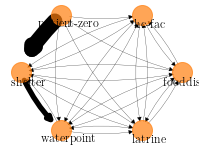

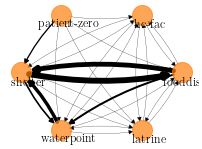

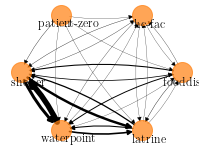

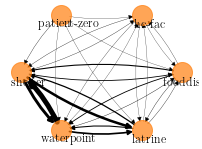

In [ ]:
### GRAPH WITH ME TRYING TO GET THE POSITIONING RIGHT 


# So for instance, evaluating scenario 1, replication 4 and the four evaluation times leads to 
a = plot_network_graph(1,9,7)
b = plot_network_graph(1,9,13)
c = plot_network_graph(1,9,35)
d = plot_network_graph(1,9,41)


## get an error for the pos.. 

In [ ]:
#### Fixing the location of the names to make it prettier

def plot_network_graph(scenario,replication, moment_of_evaluation, dict_with_graphs=dict_with_graphs):
    
    fig, ax = plt.subplots(figsize = (12, 6))
    
    pos = nx.shell_layout(dict_with_graphs[scenario][replication][moment_of_evaluation][0], scale=5)  # positions for all nodes
    
    pos_new = {}

    for k,v in pos.items():
        if v[1] > 4:
            pos_new[k] = (v[0], v[1]+0.5)
        elif v[1] < -4:
            pos_new[k] = (v[0], v[1]-0.5)
        elif v[0] > 4:
            pos_new[k] = (v[0]+0.5, v[1])
        elif v[0] < 4:
            pos_new[k] = (v[0]-0.5, v[1])

#     def nudge(pos, x_shift, y_shift):
#         return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

#     pos_nodes = nudge(pos, 0.45, -0.7)

    #list_degree=list(G.degree())                         ## this is what i added  (Eva)
    #nodes , degree = map(list, zip(*list_degree))        ## this is what i added (Eva)

    # nodes
    nx.draw_networkx_nodes(dict_with_graphs[scenario][replication][moment_of_evaluation][0], pos, node_size=400, node_color=pal_scenarios[scenario], alpha=0.3)   ## node_size used to be 400

    # edges
    nx.draw_networkx_edges(dict_with_graphs[scenario][replication][moment_of_evaluation][0],pos,width=dict_with_graphs[scenario][replication][moment_of_evaluation][1], connectionstyle='arc3, rad = 0.1') 


    nx.draw_networkx_labels(dict_with_graphs[scenario][replication][moment_of_evaluation][0], pos=pos_new, font_size = 14)
    
    plt.axis("off")
    
    #plt.title('Network model: day ' +str(moment_of_evaluation), size=16)
    plt.savefig(location_figures + "Hypothesis2.3NetworkScenario" + str(scenario) + "test_day" + str(moment_of_evaluation) + ".svg", bbox_inches="tight")
    plt.show()

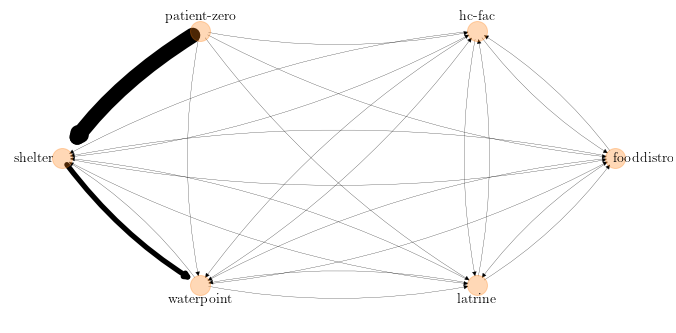

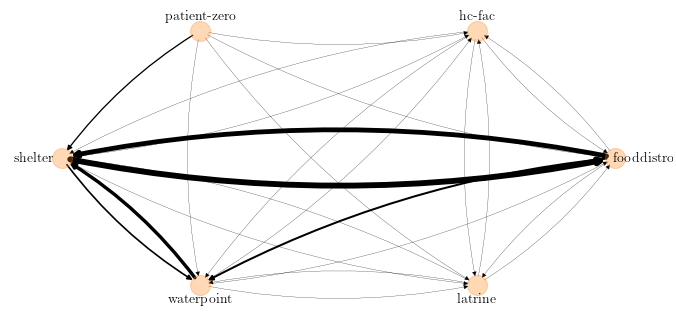

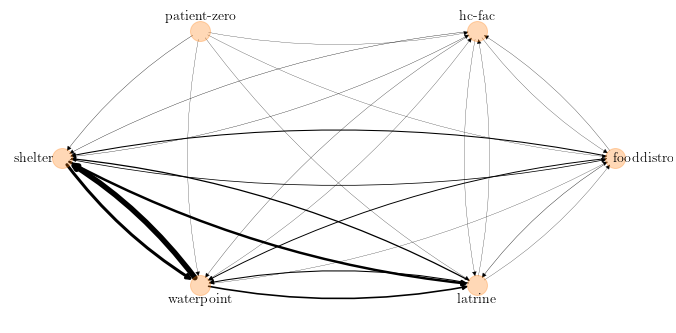

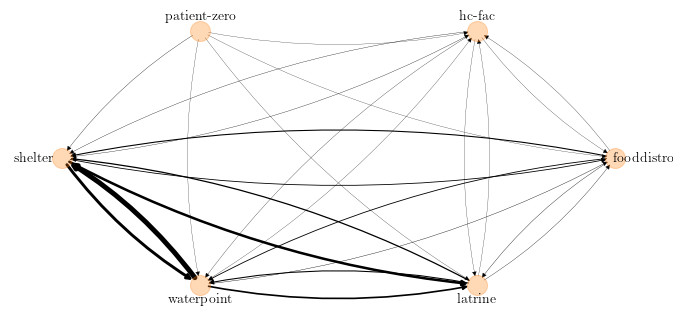

In [ ]:
a = plot_network_graph(1,9,7)
b = plot_network_graph(1,9,13)
c = plot_network_graph(1,9,35)
d = plot_network_graph(1,9,41)

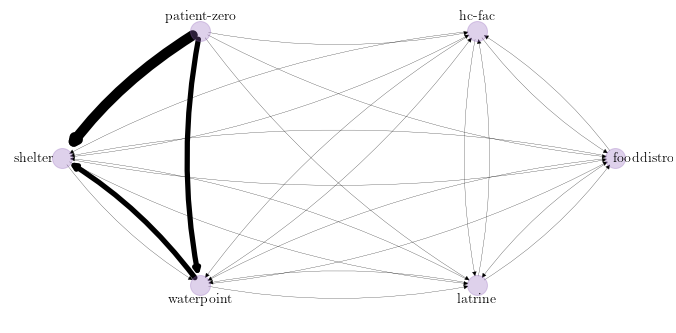

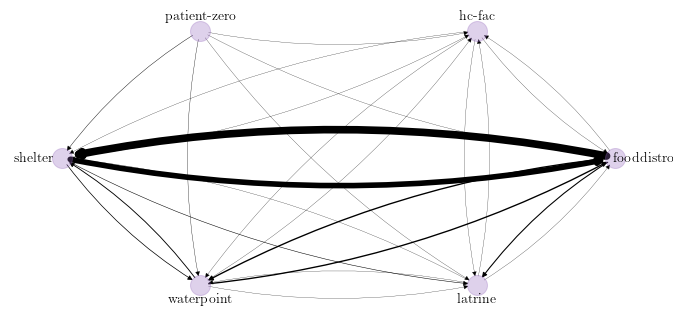

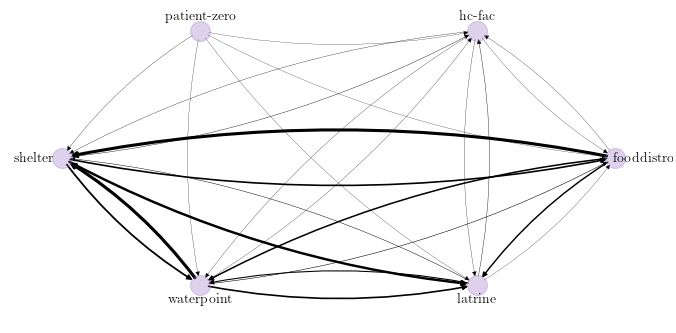

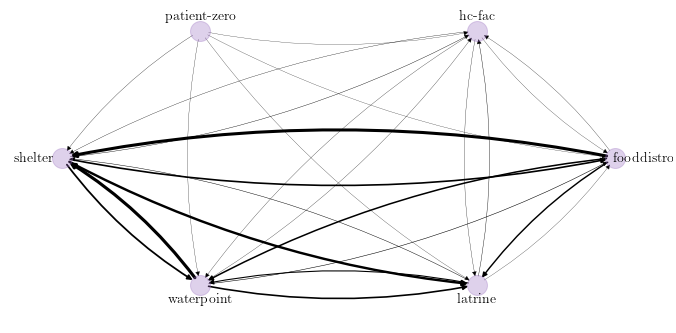

In [ ]:
# So for instance, evaluating scenario 1, replication 4 and the four evaluation times leads to 
a = plot_network_graph(3,4,7)
b = plot_network_graph(3,4,13)
c = plot_network_graph(3,4,35)
d = plot_network_graph(3,4,41)


In [ ]:
xticklabels =list()
locations = ['shelter', 'waterpoint', 'latrine', 'fooddistro', 'hc-fac','patient-zero']
from sklearn.preprocessing import normalize
for i in range(6):
    
    for j in range(10):
        if j == 5:
            
            xticklabels.append(locations[i])
        else:
            
            xticklabels.append(j)
            
for i in range(8):
    yticklabels += locations
    

    
        

ValueError: The number of FixedLocator locations (40), usually from a call to set_ticks, does not match the number of ticklabels (2560).

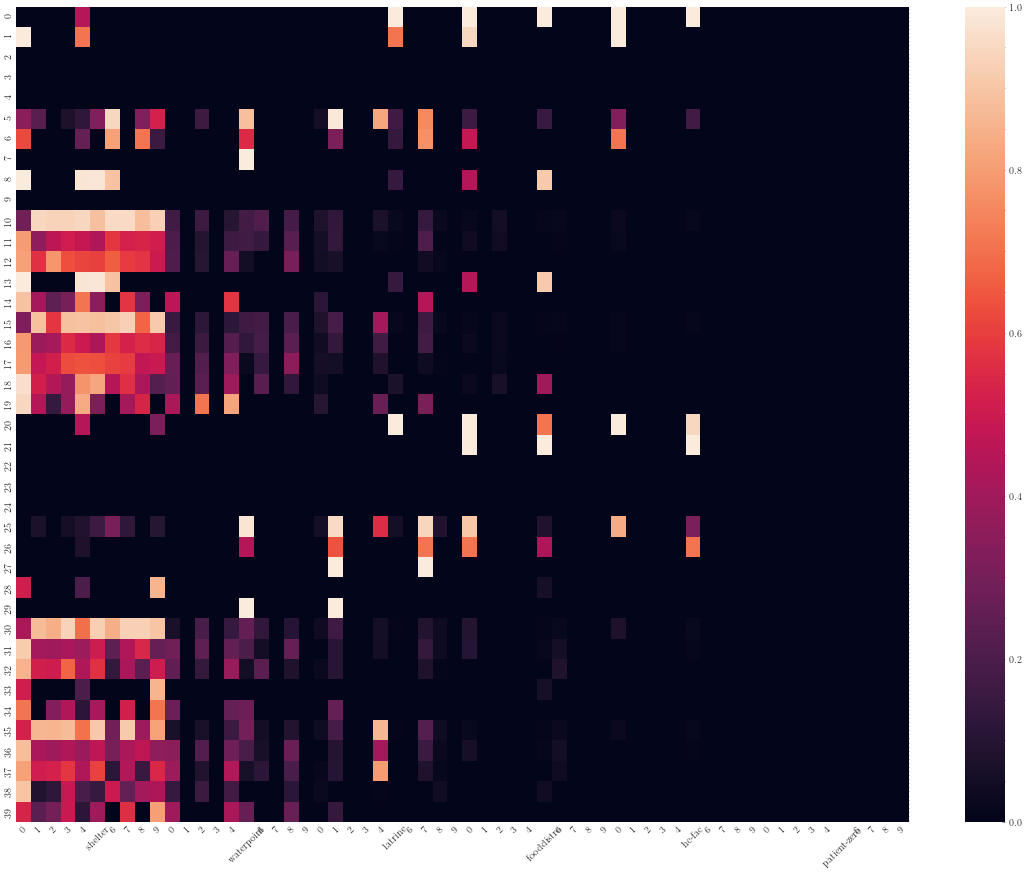

In [ ]:
matrix = np.zeros([5*4*2,6*10])  # 5 - shape of matrix 4 - points of interest 2 - scenarios of interest 6 - shape of matrix 10 - replications 

locations = ['shelter', 'waterpoint', 'latrine', 'fooddistro', 'hc-fac','patient-zero']
yticklabels = list()
for i in range(8):
    for j in locations[0:-1]:
        yticklabels.append(j)

counter_evaluationmoment = 0
counter_scenario = 0

spaces = '                                 '
xlabel = spaces
xticklabels = list()
for l in locations:
    xlabel += (l +spaces)
    for r in range(number_of_replications):
        xticklabels.append('r'+str(r))


for scenario_index in range(len(scenarios_of_interest_number)):    
    for replication in range(10):
        for evaluation_moment_index in range(len(evaluation_moments_day)):
            
            # this is because of the matrix shape
            for i in range(5):
                for j in range(6):
                    matrix[i + (scenario_index*4 + evaluation_moment_index)*5, j*10+ replication] = dict_with_networks[scenarios_of_interest_number[scenario_index]][replication][evaluation_moments_day[evaluation_moment_index]][i,j]

    
xticks = np.linspace(0,60,7)


plt.figure(figsize = (20,15))
ax = sns.heatmap(matrix)


ax.set_yticklabels(yticklabels,rotation=0,fontsize=8)
ax.set_xticklabels(xticklabels,fontsize=8)
ax.set_xlabel(xlabel)

ax.hlines(np.linspace(5,5*7,7),*ax.get_xlim(),color='lightgrey',linewidth = 4)
ax.vlines(np.linspace(10,5*10,5),*ax.get_ylim(),color='lightgrey',linewidth = 4)

plt.show()


* Put this in the appendix and just refer to it in the main text
* This map was created to show the multiple replications because we are not able to plot networks for all of them 
* This shows which replications could be interesting to dive into
* Shows the 4 moments in time and the 2 scenarios of interest

We observe:
* We can observe that 35 41 for both scenarios is quite bright  (importance of the shelter)
* Possible to cmpare the same moment in time in both scenarios 
* See changes over time 
* Regarding randomness -- 41 and 30 -- all of them are bright except for one (shelter looses importance, food distro and hc win more. it could be interesting to plot this scenario and understand why this is happening. look into the total number of infections in this run. it could be a run where the infection was contained)
* Variation inside each one of these matrices show the variation between runs


### 3.4 Agents behaving competitively are more likely to get infected  during a food distribution 

Considering these attitudes only affect their behaviour in the food distribution, this is only evaluated in this moment. However, it can be claimed that if agents behaving competitively are more likely to get infected during a food distribution, they will also be responsible for more infections when they go home and infect others 



In [ ]:
# creating matrix with the info for the day of the fooddistribution

matrix= np.zeros([number_of_replications*number_of_scenarios,8])
for scenario in total_dict:
    for replication in total_dict[scenario]:
        
        run_number = scenario * number_of_replications + 1 + replication
        selected_df = exp0df[exp0df['run'] == run_number]
        
        number_of_infections = selected_df.loc[selected_df['day'] == 41, 'cum_infected'].iloc[0]
        total_served = selected_df.loc[selected_df['day'] == 41, 'total-served'].iloc[0]
        number_comp_served = selected_df.loc[selected_df['day'] == 41, 'number-competitive-joining'].iloc[0]
        number_newcomp_served = selected_df.loc[selected_df['day'] == 41, 'number-new-competitive'].iloc[0]
        
        
        
        df = pd.DataFrame({'place':total_dict[scenario][replication][1],'attitude':total_dict[scenario][replication][2]})
        # filter to get only the infections that happened until day 9
        df = df.iloc[0:number_of_infections]  

        # from these, get the infections that happened at the food distribution
        df = df['attitude'][df['place']=='fooddistro']
        

        
        nbr_coop_infected = 0
        nbr_comp_infected = 0
        nbr_ncomp_infected = 0
        
        # count the number of cooperative and competitive people who got infected at the food distribution
        for index, value in df.items():
            
            if value == 'cooperative':
                nbr_coop_infected = nbr_coop_infected + 1
            if value == 'competitive':
                nbr_comp_infected = nbr_comp_infected + 1
            if value == 'new-competitive':
                nbr_ncomp_infected = nbr_ncomp_infected + 1
                
        
        matrix[number_of_replications*scenario+replication,0] = scenario
        matrix[number_of_replications*scenario+replication,1] = replication
        matrix[number_of_replications*scenario+replication,2] = total_served
        matrix[number_of_replications*scenario+replication,3] = number_comp_served
        matrix[number_of_replications*scenario+replication,4] = number_newcomp_served
        matrix[number_of_replications*scenario+replication,5] = nbr_comp_infected
        matrix[number_of_replications*scenario+replication,6] = nbr_coop_infected 
        matrix[number_of_replications*scenario+replication,7] = nbr_ncomp_infected 


matrix = pd.DataFrame(matrix, columns = ["scenario", "replication", "total-served", "competitive-served", "new-competitive-served", "competitive-infected", "cooperative-infected", "new-competitive-infected" ])


# Calculating likelihoods

# COMPETITIVE: nbr of competitive people infected in the food distribution / nbr of competitive people served (number of competitive people served)
# COOPERATIVE: nbr of cooperative people infected in the first food distribution / nbr of cooperative people served (total-served - number of competitive people served)

# likelihood cooperative
#matrix["likelihood-cooperative"] = matrix["cooperative-infected"] / (matrix["total-served"] - matrix["competitive-served"] - matrix["new-competitive-served"]) 
matrix["Cooperative"] = matrix["cooperative-infected"] / (matrix["total-served"] - matrix["competitive-served"]) 
# likelihood competitive
#matrix["likelihood-competitive"] = matrix["competitive-infected"] / (matrix["new-competitive-served"] + matrix["competitive-served"])
matrix["Competitive"] = matrix["competitive-infected"] /  matrix["competitive-served"]
# likelihood new competitive
matrix['New-competitive'] = matrix["new-competitive-infected"] /  matrix["new-competitive-served"]


# Preparing data for visualization
matrix = matrix.melt(id_vars=['scenario', 'replication'], 
              value_vars=[ "Cooperative", "Competitive", "New-competitive"],
              var_name='Attitude', value_name='Likelihood')

### 

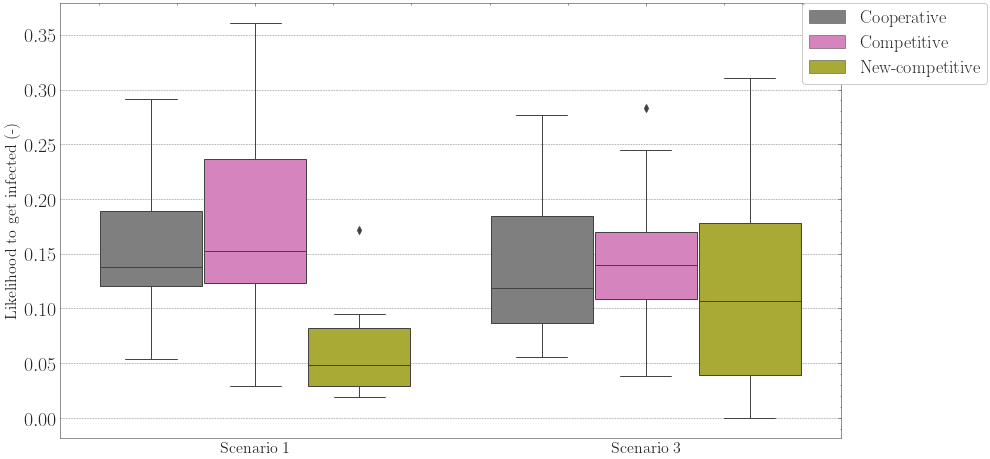

In [ ]:
fig, ax = plt.subplots(figsize = (14, 8))

# Visualization (only scenario 1 and scenario 3)
matrix = matrix[(matrix['scenario'] == 1.0) | (matrix['scenario'] == 3.0)]
#matrix = matrix[matrix['scenario'] != 4.0]
sns.boxplot(x='scenario', y='Likelihood', hue='Attitude', data=matrix, palette=pal_attitudes, ax = ax)  

#plt.xlabel("Scenario", size = 16)
ax.set_ylabel("Likelihood to get infected (-)", size = 16)
ax.set_xlabel(None)
ax.set_xticklabels(["Scenario 1", "Scenario 3"], size = 16)
ax.tick_params(axis='y', labelsize=20)

plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0, fontsize='x-large', prop={'size':18})
plt.savefig(location_figures + "Hypothesis2.4LikelihoodGetInfected_PerAttitude.svg")

In [ ]:
## the next one follows the same logic... if competitive people are more likely to get infected, they are more likely to infect others as well (since this depends on how long they spend and how close they are to ohters)

### 3.5 The competitive agent is more likely to infect other people


Similarly, this is looking into the infections happening at the food distribution. However, now the focus is on the attitude of the infector and not the infectee.



In [ ]:
# creating matrix with the info for the day of the fooddistribution

matrix= np.zeros([number_of_replications*number_of_scenarios,10])
for scenario in total_dict:
    for replication in total_dict[scenario]:
        
        run_number = scenario * number_of_replications + 1 + replication
        selected_df = exp0df[exp0df['run'] == run_number]
        
        number_of_infections = selected_df.loc[selected_df['day'] == 41, 'cum_infected'].iloc[0]
        total_served = selected_df.loc[selected_df['day'] == 41, 'total-served'].iloc[0]
        number_comp_served = selected_df.loc[selected_df['day'] == 41, 'number-competitive-joining'].iloc[0]
        number_newcomp_served = selected_df.loc[selected_df['day'] == 41, 'number-new-competitive'].iloc[0]
        
        # if i want to include the number of infectious people around 
        number_infectious_comp = selected_df.loc[selected_df['day'] == 41, 'nbr-infectious-competitive'].iloc[0]
        number_infectious_coop = selected_df.loc[selected_df['day'] == 41, 'nbr-infectious-cooperative'].iloc[0]

        ### now with the focus on the infector (hence the [4])
        df = pd.DataFrame({'place':total_dict[scenario][replication][1],'attitude':total_dict[scenario][replication][4]})
        # filter to get only the infections that happened until day 9
        df = df.iloc[0:number_of_infections]  

        # from these, get the infections that happened at the food distribution
        df = df['attitude'][df['place']=='fooddistro']
        

        
        nbr_coop_infector = 0
        nbr_comp_infector = 0
        nbr_ncomp_infector = 0
        
        # count the number of cooperative and competitive people who got infected at the food distribution
        for index, value in df.items():
            
            if value == 'cooperative':
                nbr_coop_infector = nbr_coop_infector + 1
            if value == 'competitive':
                nbr_comp_infector = nbr_comp_infector + 1
            if value == 'new-competitive':
                nbr_ncomp_infector = nbr_ncomp_infector + 1
           
        # took it out to experiment
           # if value == 'new-competitive':
           #     nbr_ncomp_infector = nbr_ncomp_infector + 1
        
        matrix[number_of_replications*scenario+replication,0] = scenario
        matrix[number_of_replications*scenario+replication,1] = replication
        matrix[number_of_replications*scenario+replication,2] = total_served
        matrix[number_of_replications*scenario+replication,3] = number_comp_served
        matrix[number_of_replications*scenario+replication,4] = number_newcomp_served
        matrix[number_of_replications*scenario+replication,5] = nbr_comp_infector
        matrix[number_of_replications*scenario+replication,6] = nbr_coop_infector 
        matrix[number_of_replications*scenario+replication,7] = nbr_ncomp_infector 
        matrix[number_of_replications*scenario+replication,8] = number_infectious_comp
        matrix[number_of_replications*scenario+replication,9] = number_infectious_coop

        
matrix = pd.DataFrame(matrix, columns = ["scenario", "replication", "total-served", "competitive-served", "new-competitive-served", "competitive-infector", "cooperative-infector", "new-competitive-infector", "number-infectious-comp", "number-infectious-coop"])

#matrix["Cooperative"] = matrix["cooperative-infector"] / (matrix["total-served"] - matrix["competitive-served"]) 
#matrix["Competitive"] = matrix["competitive-infector"] / matrix["competitive-served"]
#matrix["New-competitive"] = matrix["new-competitive-infector"] / matrix["new-competitive-served"]

# what if i calculate this dividing by the total number infectious wth that behaviour?
matrix["Cooperative"] = ((matrix["cooperative-infector"] + matrix["new-competitive-infector"]) / (matrix["number-infectious-coop"] * (matrix['total-served'] - matrix['competitive-served'] ))) * 10
matrix["Competitive"] = (matrix["competitive-infector"] / (matrix['number-infectious-comp'] * matrix['competitive-served'])) * 10 



# Preparing data for visualization
matrix = matrix.melt(id_vars=['scenario', 'replication'], 
              value_vars=[ "Cooperative", "Competitive"],
              var_name='Attitude', value_name='Likelihood infecting')


### 

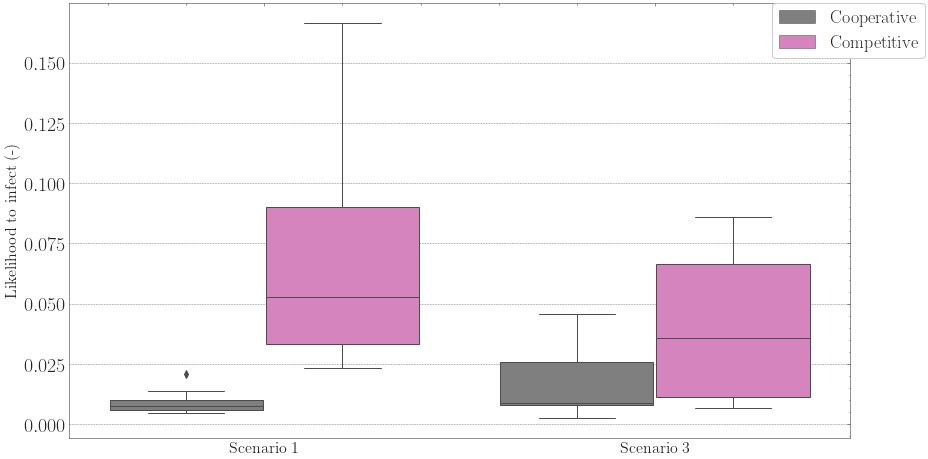

In [ ]:
fig, ax = plt.subplots(figsize = (14, 8))

# Selecting the scenarios of interest
matrix = matrix[(matrix['scenario'] == 1.0) | (matrix['scenario'] == 3.0)]
#matrix = matrix[matrix['scenario'] != 4.0]
sns.boxplot(x='scenario', y='Likelihood infecting', hue='Attitude', data=matrix, palette=pal_attitudes, ax = ax)  
ax.set_ylabel("Likelihood to infect (-)", size = 16)
ax.set_xlabel(None)
ax.set_xticklabels(["Scenario 1", "Scenario 3"], size = 16)
ax.tick_params(axis='y', labelsize=20)

plt.legend(bbox_to_anchor=(0.90, 1), loc='upper left', borderaxespad=0, fontsize='x-large', prop={'size':18})

plt.savefig(location_figures + "Hypothesis2.5LikelihoodToInfect_PerAttitude.svg")

####### maaaas, nao devia ter em consideraçao os que estão infetados? entao em vez de dividir os que sao servidos mas pelos que sao servidos E infetados

In [ ]:
# I can go three ways with this graph

# 1. Just say that the graph before should be a proxy (if they are likely to get infected, they are likely to infect)
# 2. Calculate the number of infections caused by a competitive at food / number of competitive served (misses the number of people who were actually infected)
# 3. Calculate the number of infections caused by a competitive at food / number of competitive infectious (not sure how amny of hem attended the food distro, but could count as a proxy )

### or combining the last two 

# 4. Calculate the number of infections caused by a competitive at food distribution / (nbr of competitive served * number of competitive infected in the camp )


#### Finally, I should look into R0

### 3.6 Looking into R0

In [ ]:
scenarios_of_interest

[10, 30]

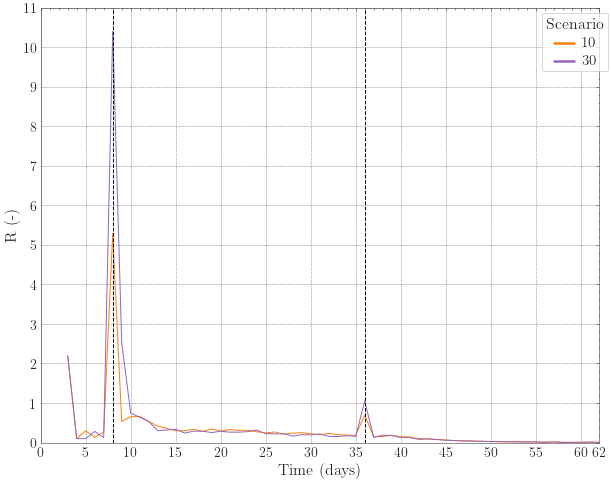

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

for j in scenarios_of_interest:
    df = exp0df
    df = df[df['scenario:percentage-competitive'] == j]
    df.groupby('day').mean()['R0'].plot(ax=ax, label=j, color = pal_scenarios_10[j])
ax.legend()

#for moments in evaluation_moments_day:
#    ax.axvline(x=moments, color = "black", linestyle = "--")

ax.axvline(x=8, color = "black", linestyle = "--")
ax.axvline(x=36, color = "black", linestyle = "--")

leg = plt.legend(loc='upper right', bbox_to_anchor=(1.025, 1),framealpha=0.75,title='Scenario',title_fontsize=16)
# get the individual lines inside legend and set line width

# Adjust the linewidth of the legend
for line in leg.get_lines():
    line.set_linewidth(2.5)
for text in leg.get_texts():
    text.set_fontsize(15)
    

# Correct xticks, make it 'convenient' to read what you need to read (i guess interval of 5 days )
ax.set_xlim([0,df['day'].max()])

xticks = np.linspace(0,60,13)
xticks = np.append(xticks,62)

xticklabels = list() # 
for xt in range(len(xticks)):
    xticklabels.append( str(int(xticks[xt])))
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,fontsize=14)

# Correct yticks, again, make them convenient. the default 100 is a good step here i guess 
# Correct y-lim
ax.set_ylim([0,11])

ax.set_ylabel('R (-)', fontsize = 16)

yticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

yticklabels = list() # 
for yt in range(len(yticks)):
    yticklabels.append( str(int(yticks[yt])))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=14)
    
   
# ax.legend(labels=scenario_names)
ax.set_xlabel('Time (days)', fontsize = 16)
#fig.suptitle('Cumulative infections: Baseline in each scenario', fontsize=20)
plt.savefig(location_figures + "Hypothesis2.6R0.svg")


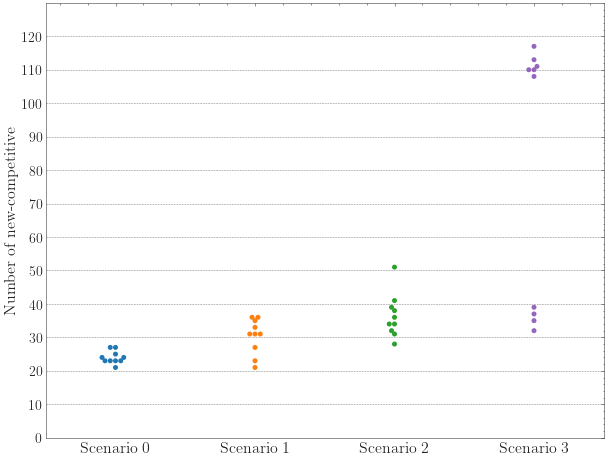

In [ ]:
### Trying to visualize the number of people turning new-competitive per scenario

### Looking into how many people turned new-competitive per run per scenario
exp0df_newcomp = exp0df[exp0df['scenario:percentage-competitive'] != 40]
exp0df_newcomp = exp0df_newcomp[exp0df_newcomp['day'] == 9]

exp0df_newcomp

fig, ax = plt.subplots(figsize=(10,8))

sns.swarmplot(x='scenario:percentage-competitive', y='number-new-competitive', hue='scenario:percentage-competitive', data=exp0df_newcomp, palette = pal_scenarios_10, ax = ax)  
ax.get_legend().remove()

ax.set_xticklabels(["Scenario 0", "Scenario 1", "Scenario 2", "Scenario 3"], size = 16)
ax.set_xlabel(None)
ax.set_ylabel("Number of New Competitve People (-)")

# Correct yticks, again, make them convenient. the default 100 is a good step here i guess 
# Correct y-lim
ax.set_ylim([0,130])

yticks = np.arange(0,130,10)

yticklabels = list() # 
for yt in range(len(yticks)):
    yticklabels.append( str(int(yticks[yt])))
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,fontsize=14)

#plt.xlabel("Scenario", size = 16)
plt.ylabel("Number of new-competitive", size = 16)

plt.savefig(location_figures + "Hypothesis2.7NumberNewComp_Base.svg")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ff502ce8-25da-4e4a-b841-dc0e7d23f282' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>